In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
from datetime import datetime, timedelta
import cmocean
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')
import glob
import pandas as pd
import xarray as xr
from sklearn.neighbors import LocalOutlierFactor

## load in fancy model
from sklearn import preprocessing 
import statsmodels.api as sm
import warnings; warnings.simplefilter('ignore')

# load in other fancy model
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing


In [3]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

In [4]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
## new adjusted temps (no smoothing)
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814.nc'
# simba_fname = 'firnprofile-combined-corrected.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'
# simba_fname = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'
# simba_fname = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240821_created_June26_2025.nc'
simba_fname = 'firnprofile-combined-corrected-at38.sled.level2.beta.15min.20240517-20240821_created_June26_2025.nc'

season_data = {}
varnames = ['temperature','initial_height','time']
fdic = load_netcdf(simba_filepath+simba_fname, varnames)

fstart_time = datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')

fdic['dates'] = np.asarray([fstart_time+timedelta(minutes=int(m)) for m in fdic['time']])

for var in ['temperature','dates','initial_height']:
    season_data[var] = fdic[var]


In [5]:
simba_temps = season_data['temperature']
simba_heights = season_data['initial_height']
simba_dates = season_data['dates']

In [23]:
## these are opposite of previous file! why, michael???
print(simba_heights) 

[-118 -116 -114 -112 -110 -108 -106 -104 -102 -100  -98  -96  -94  -92
  -90  -88  -86  -84  -82  -80  -78  -76  -74  -72  -70  -68  -66  -64
  -62  -60  -58  -56  -54  -52  -50  -48  -46  -44  -42  -40  -38  -36
  -34  -32  -30  -28  -26  -24  -22  -20  -18  -16  -14  -12  -10   -8
   -6   -4   -2    0    2    4    6    8   10   12   14   16   18   20
   22   24   26   28   30   32   34   36   38   40   42   44   46   48
   50   52   54   56   58   60   62   64   66   68   70   72   74   76
   78   80   82   84   86   88   90   92   94   96   98  100  102  104
  106  108  110  112  114  116  118  120  122  124  126  128  130  132
  134  136  138  140  142  144  146  148  150  152  154  156  158  160
  162  164  166  168  170  172  174  176  178  180  182  184  186  188
  190  192  194  196  198  200]


In [34]:
vert_grad = np.gradient(simba_temps, simba_heights,  axis=1)
second_vert_grad = np.gradient(vert_grad, simba_heights, axis=1)

time_grad = np.gradient(simba_temps, axis=0)
second_time_grad = np.gradient(time_grad, axis=0)

In [35]:
scaled_variables = {}
for var, label in zip([vert_grad, second_vert_grad,simba_temps,time_grad,second_time_grad,],['dTdz','d2Tdz2','T','dTdt','d2Tdt2','dTdtdz']):

    print(label)
    zeroed_var = np.ma.masked_invalid(var.copy())
    zeroed_var[zeroed_var.mask] = 0
    scaled_variables[label] = preprocessing.normalize(zeroed_var, axis=1)

dTdz
d2Tdz2
T
dTdt
d2Tdt2


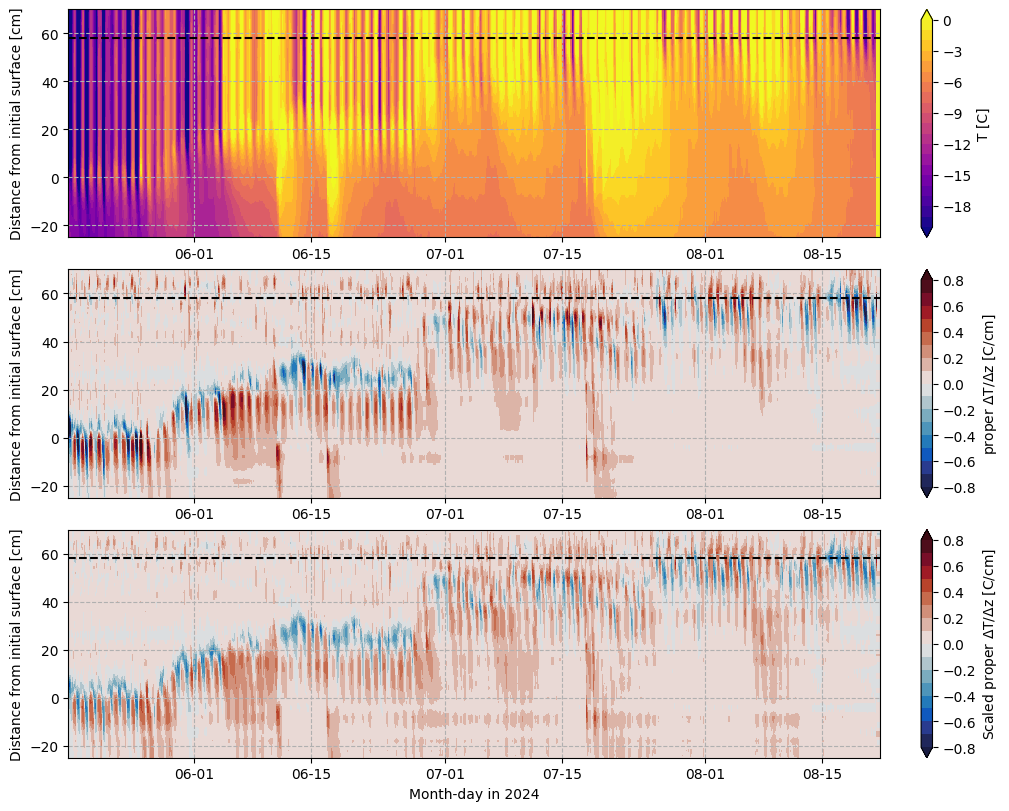

In [44]:

fig, axs = plt.subplots(3, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_temps,0,1),
                cmap=plt.cm.plasma, levels=np.arange(-20,1,1), extend='both')
plt.colorbar(cb, label='T [C]', ax=axs[0])

cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=axs[1])

cb = axs[2].contourf(simba_dates, simba_heights, np.swapaxes(scaled_variables['dTdz'],0,1),
                cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
plt.colorbar(cb, label='Scaled proper $\Delta$T/$\Delta$z [C/cm]', ax=axs[2])

for ax in axs.ravel():
    ax.axhline(y=58, c='k', ls='--') ## cutoff from bottom to top thermistor
    ax.grid(ls='--')
    # ax.set_xlim(datetime(2024,5,17), datetime(2024,6,1))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel('Distance from initial surface [cm]')

axs[-1].set_xlabel('Month-day in 2024')
    
axs[0].set_ylim(-25,70)
# axs[0].set_ylim(-25,20)

# plt.savefig(plrams_fpath+'SIMBA_uncorrected_dTdz-d2Tdz2_sfc-detection.png', dpi=300)
plt.show()

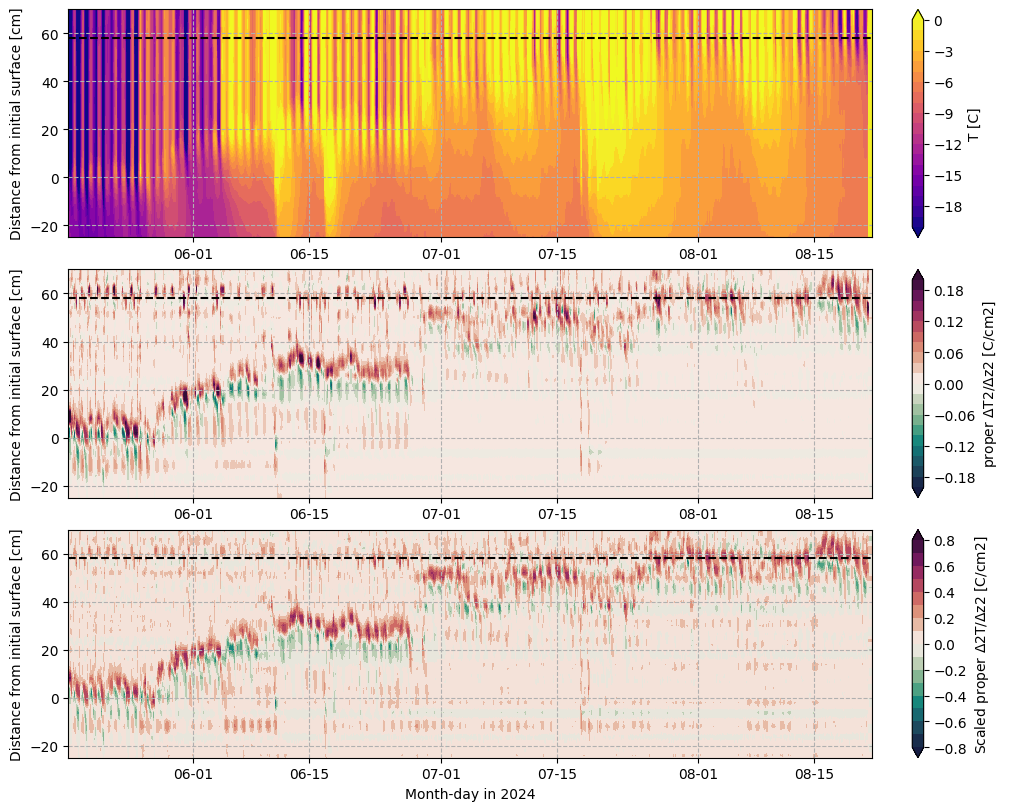

In [43]:

fig, axs = plt.subplots(3, figsize=(10,8), sharey=True, constrained_layout=True)


cb = axs[0].contourf(simba_dates, simba_heights, np.swapaxes(simba_temps,0,1),
                cmap=plt.cm.plasma, levels=np.arange(-20,1,1), extend='both')
plt.colorbar(cb, label='T [C]', ax=axs[0])

cb = axs[1].contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-.2,.21,.02), extend='both')
plt.colorbar(cb, label='proper $\Delta$T2/$\Delta$z2 [C/cm2]', ax=axs[1])

cb = axs[2].contourf(simba_dates, simba_heights, np.swapaxes(scaled_variables['d2Tdz2'],0,1),
                cmap=cmocean.cm.curl, levels=np.arange(-.8,.81,.1), extend='both')
plt.colorbar(cb, label='Scaled proper $\Delta$2T/$\Delta$z2 [C/cm2]', ax=axs[2])

for ax in axs.ravel():
    ax.axhline(y=58, c='k', ls='--') ## cutoff from bottom to top thermistor
    ax.grid(ls='--')
    # ax.set_xlim(datetime(2024,5,17), datetime(2024,6,1))
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_ylabel('Distance from initial surface [cm]')

axs[-1].set_xlabel('Month-day in 2024')
    
axs[0].set_ylim(-25,70)
# axs[0].set_ylim(-25,20)

# plt.savefig(plrams_fpath+'SIMBA_uncorrected_dTdz-d2Tdz2_sfc-detection.png', dpi=300)
plt.show()

## start trying to ID surface, or at least what we think the surface is

In [52]:
simba_dates_2d = np.repeat(simba_dates.copy()[:,np.newaxis], simba_temps.shape[1], axis=1)
simba_heights_2d = np.repeat(simba_heights.copy()[np.newaxis,:], simba_temps.shape[0], axis=0)

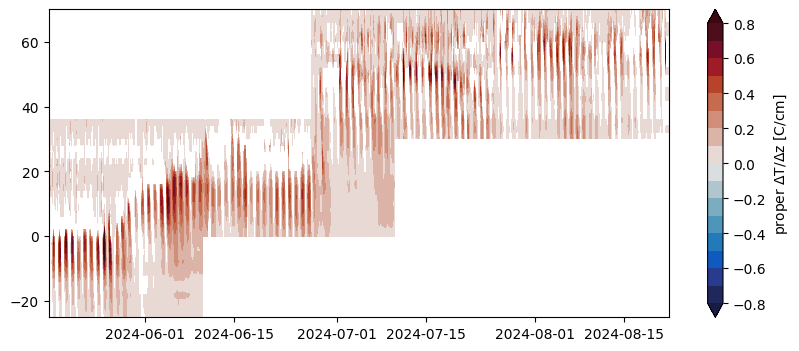

In [79]:
masked_dTdz = np.ma.masked_less(vert_grad.copy(), 0.)
# masked_dTdz = np.ma.masked_less(scaled_variables['dTdz'].copy(), 0)


masked_dTdz = np.ma.masked_where( (simba_dates_2d<datetime(2024,6,27,1))&(simba_heights_2d>36), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,6,10))&(simba_heights_2d<0), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,7,10))&(simba_heights_2d<30), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,6,27))&(simba_heights_2d>70), masked_dTdz)


fig, axs = plt.subplots(1, figsize=(10,4))#, sharey=True, constrained_layout=True)

cb = plt.contourf(simba_dates, simba_heights, np.swapaxes(masked_dTdz,0,1),
                cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]')
plt.ylim(-25,70)

plt.show()

In [81]:
## still inefficient but understandable
masked_dTdz_sfc = []

for i in range(masked_dTdz.shape[0]):
    timestep_var = masked_dTdz[i,:]
    max_height = simba_heights[np.ma.where(timestep_var==np.ma.max(timestep_var))[0]]

    if len(max_height)!=1:
        masked_dTdz_sfc.append(np.nan)
    else:
        masked_dTdz_sfc.append(max_height[0])

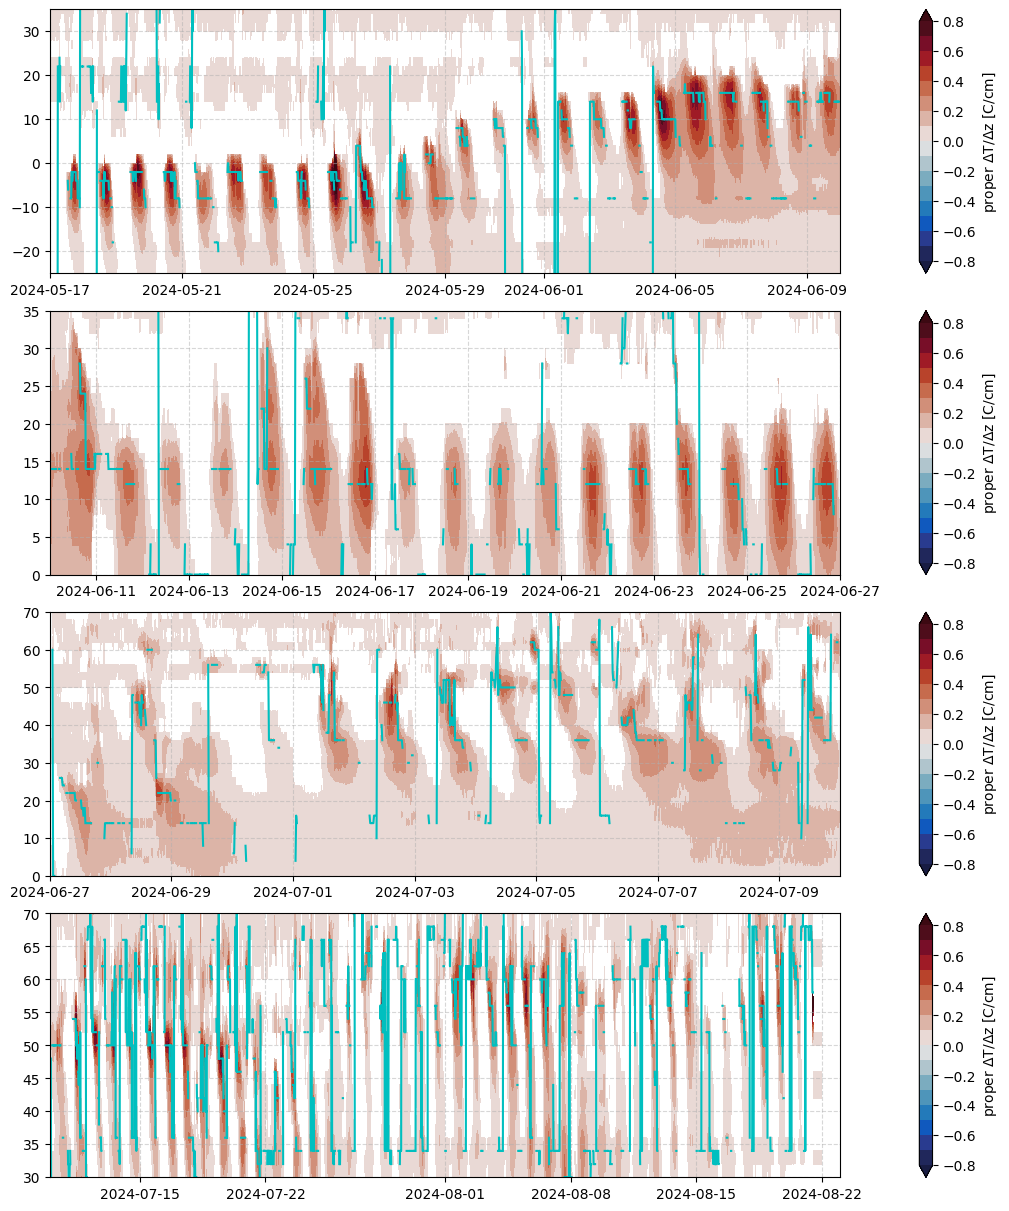

In [83]:
fig, axs = plt.subplots(4, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(masked_dTdz,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, masked_dTdz_sfc, c='c')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

In [89]:
## still inefficient but understandable
masked_d2Tdz2_sfc = []

masked_d2Tdz2 = np.ma.masked_array(scaled_variables['d2Tdz2'], mask=masked_dTdz.mask)

for i in range(masked_d2Tdz2.shape[0]):
    timestep_var = masked_d2Tdz2[i,:]
    max_height = simba_heights[np.ma.where(timestep_var==np.ma.min(timestep_var))[0]]

    if len(max_height)!=1:
        masked_d2Tdz2_sfc.append(np.nan)
    else:
        masked_d2Tdz2_sfc.append(max_height[0])

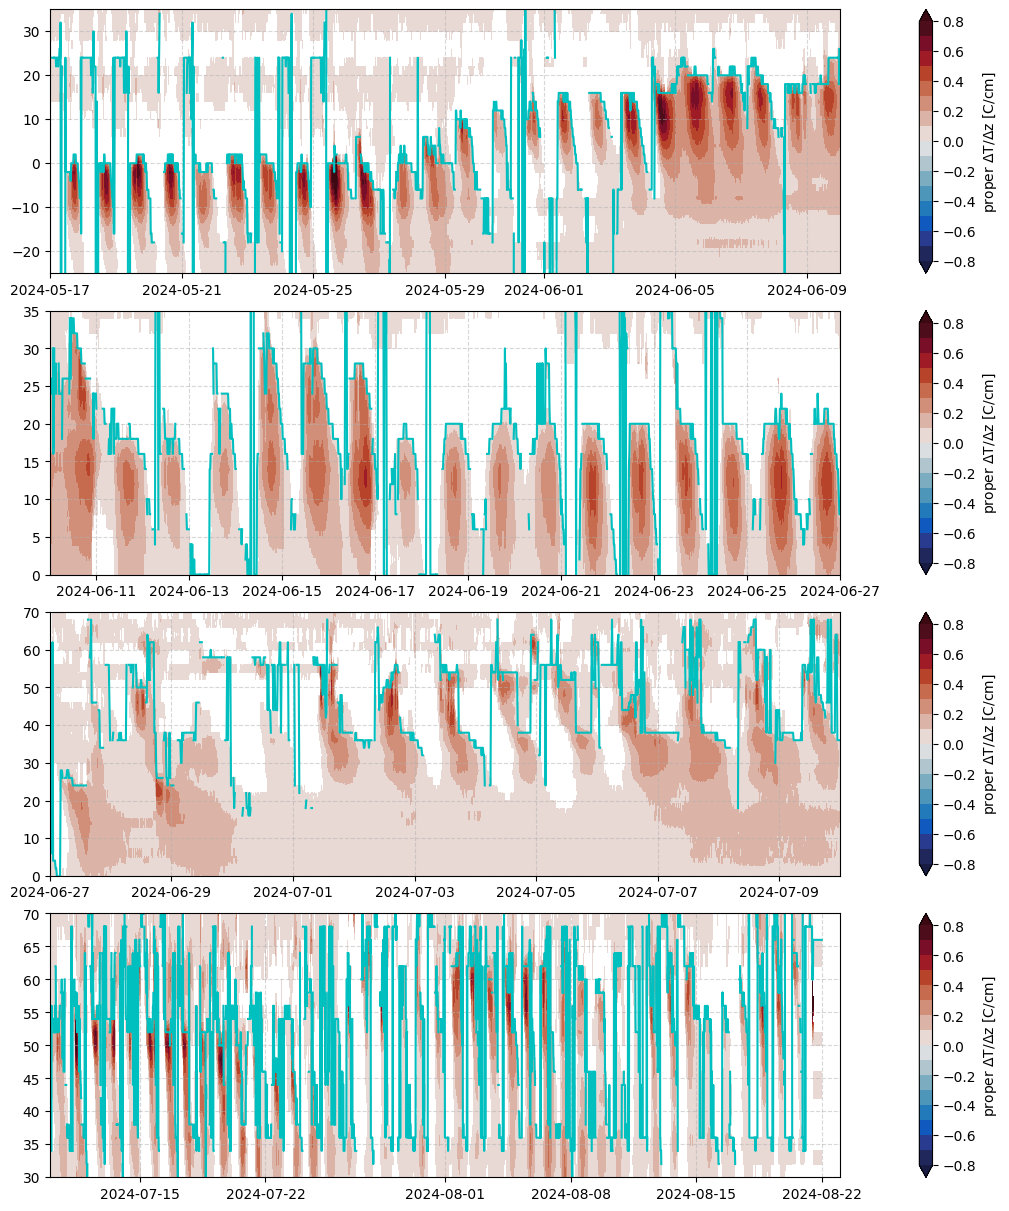

In [90]:
fig, axs = plt.subplots(4, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(masked_dTdz,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, masked_d2Tdz2_sfc, c='c')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

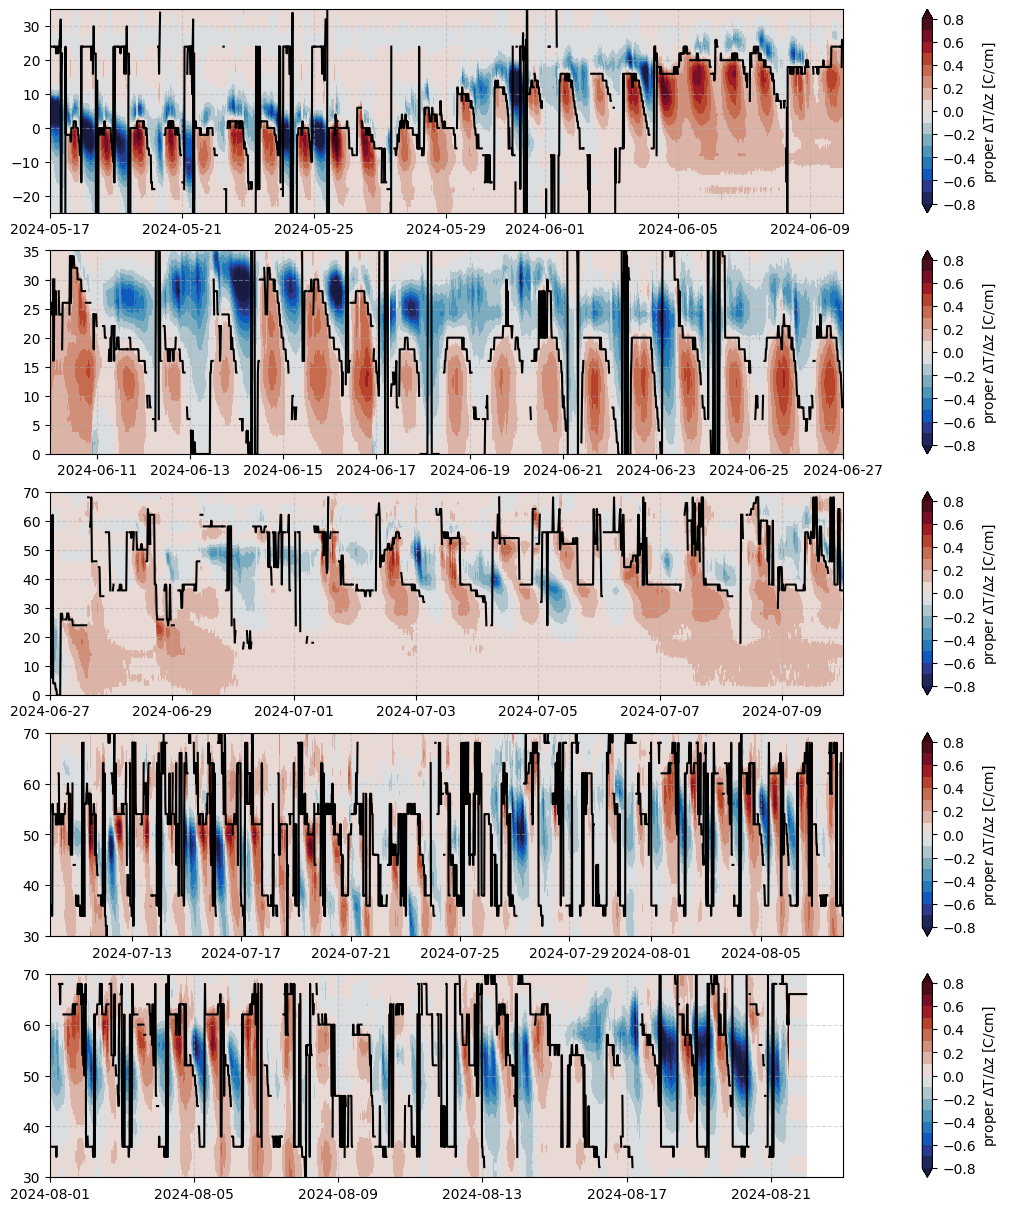

In [94]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, masked_d2Tdz2_sfc, c='k')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

### try adding dT/dz variance as condition

In [97]:
## calculate dT/dz variances with different window sizes
variances_center = {}

# windows = [4, 4*2, 4*4, 4*6, 4*10, 4*12, 4*18, 4*24, 4*48]
windows = 4*np.arange(4,25,4)

# for var, label in zip([vert_grad, second_vert_grad,simba_temps,time_grad,second_time_grad,dTdtdz],['dTdz','d2Tdz2','T','dTdt','d2Tdt2','dTdtdz']):
for var, label in zip([vert_grad, second_vert_grad,simba_temps,time_grad,second_time_grad,],['dTdz','d2Tdz2','T','dTdt']):

    variances_center[label] = {}
    print(label)
    for window in windows:
        print(window)
        
        for i in range(vert_grad.shape[0]):
            # if i-int(window/2)<0:
            #     time_step_var = np.full(var.shape[0], -999)
            #     if i==0:
            #         rolling_var_from_vert_win = time_step_var[np.newaxis,:]
            #     else:
            #         rolling_var_from_vert_win = np.ma.concatenate((rolling_var_from_vert_win, time_step_var[np.newaxis,:]))
            #     continue
            # print(i-window/2, i+window/2+1)

            try:
                time_step_var = np.ma.var(np.ma.masked_invalid(var[i-int(window/2):i+int(window/2)+1,:]), axis=0)
            except:
                time_step_var = np.full(var.shape[0], -999)
                print(simba_dates[i], np.shape(time_step_var))
            # print(i, time_step_var.shape)
            if i==0:
                rolling_var_from_vert_win = time_step_var[np.newaxis,:]
            else:
                rolling_var_from_vert_win = np.ma.concatenate((rolling_var_from_vert_win, time_step_var[np.newaxis,:]))
                
        variances_center[label][window] = rolling_var_from_vert_win
print(variances_center.keys())

dTdz
16
32
48
64
80
96
d2Tdz2
16
32
48
64
80
96
T
16
32
48
64
80
96
dTdt
16
32
48
64
80
96
dict_keys(['dTdz', 'd2Tdz2', 'T', 'dTdt'])


In [131]:
scaled_variances_center = {}
for varname in variances_center:
    print(varname)
    scaled_variances_center[varname] = {}
    for win in variances_center[varname]:
    
        # if win in []
        data = np.copy(variances_center[varname][win])
        data[np.where(simba_heights_2d>100)] = 0.
        data[np.where(simba_heights_2d<-50)] = 0.

        scaled_variances_center[varname][win] = preprocessing.normalize(data, axis=1)

dTdz
d2Tdz2
T
dTdt


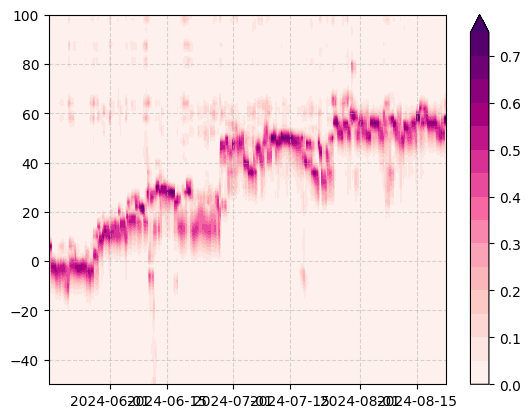

In [136]:
cb = plt.contourf(simba_dates,simba_heights,np.swapaxes(scaled_variances_center['dTdz'][24*4],0,1), 
                  levels=np.arange(0,0.8,.05), extend='max', cmap=plt.cm.RdPu)
plt.colorbar(cb)
plt.grid(alpha=.5, ls='--')
plt.ylim(-50,100)
# plt.xlim(datetime(2024,8,1),datetime(2024,8,23))
plt.show()

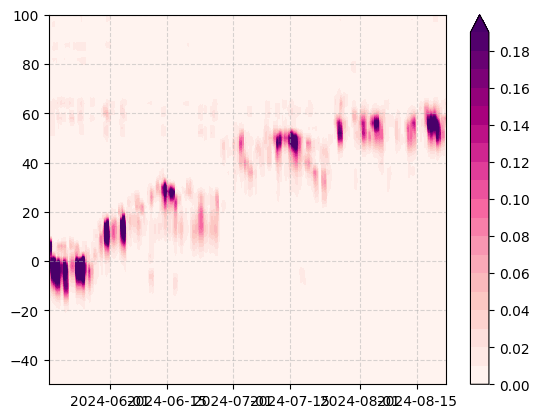

In [140]:
cb = plt.contourf(simba_dates,simba_heights,np.swapaxes(variances_center['dTdz'][24*4],0,1), 
                  levels=np.arange(0,0.2,.01), extend='max', cmap=plt.cm.RdPu)
plt.colorbar(cb)
plt.grid(alpha=.5, ls='--')
plt.ylim(-50,100)
# plt.xlim(datetime(2024,8,1),datetime(2024,8,23))
plt.show()

In [150]:
masked_dTdz = np.ma.masked_less(second_vert_grad.copy(), 0.)
# masked_dTdz = np.ma.masked_less(scaled_variables['dTdz'].copy(), 0)

masked_dTdz = np.ma.masked_where( (simba_dates_2d<datetime(2024,6,27,1))&(simba_heights_2d>36), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,6,10))&(simba_heights_2d<0), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,7,10))&(simba_heights_2d<30), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,6,27))&(simba_heights_2d>70), masked_dTdz)

masked_dTdz = np.ma.masked_where( scaled_variances_center['dTdz'][24*4]<0.01, masked_dTdz)

In [151]:
masked_d2Tdz2_sfc = []

masked_d2Tdz2 = np.ma.masked_array(second_vert_grad, mask=masked_dTdz.mask)

for i in range(masked_d2Tdz2.shape[0]):
    timestep_var = masked_d2Tdz2[i,:]
    max_height = simba_heights[np.ma.where(timestep_var==np.ma.min(timestep_var))[0]]

    if len(max_height)!=1:
        masked_d2Tdz2_sfc.append(np.nan)
    else:
        masked_d2Tdz2_sfc.append(max_height[0])

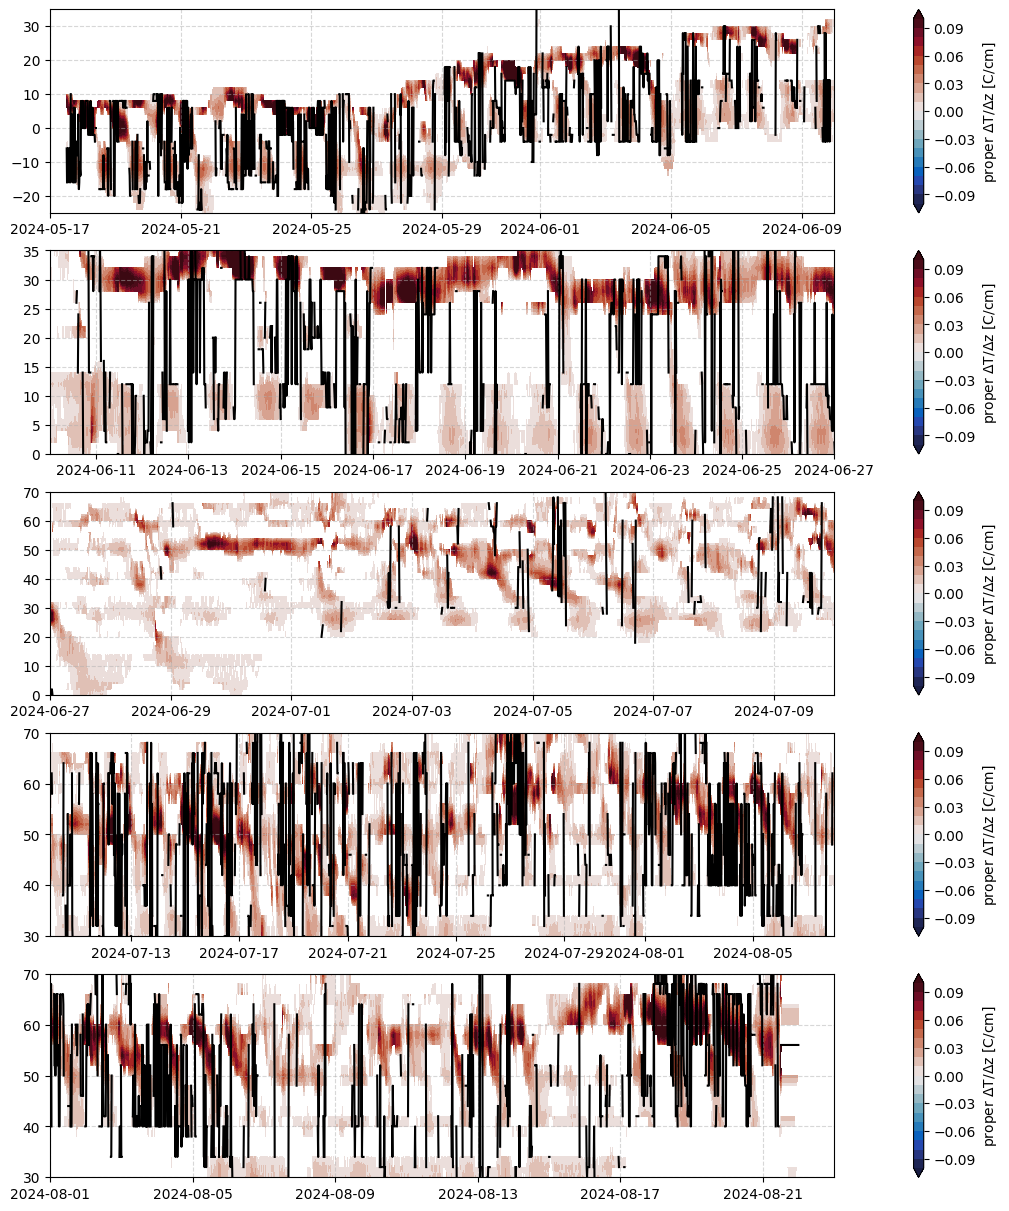

In [152]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(masked_d2Tdz2,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.1,.11,.01), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, masked_d2Tdz2_sfc, c='k')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

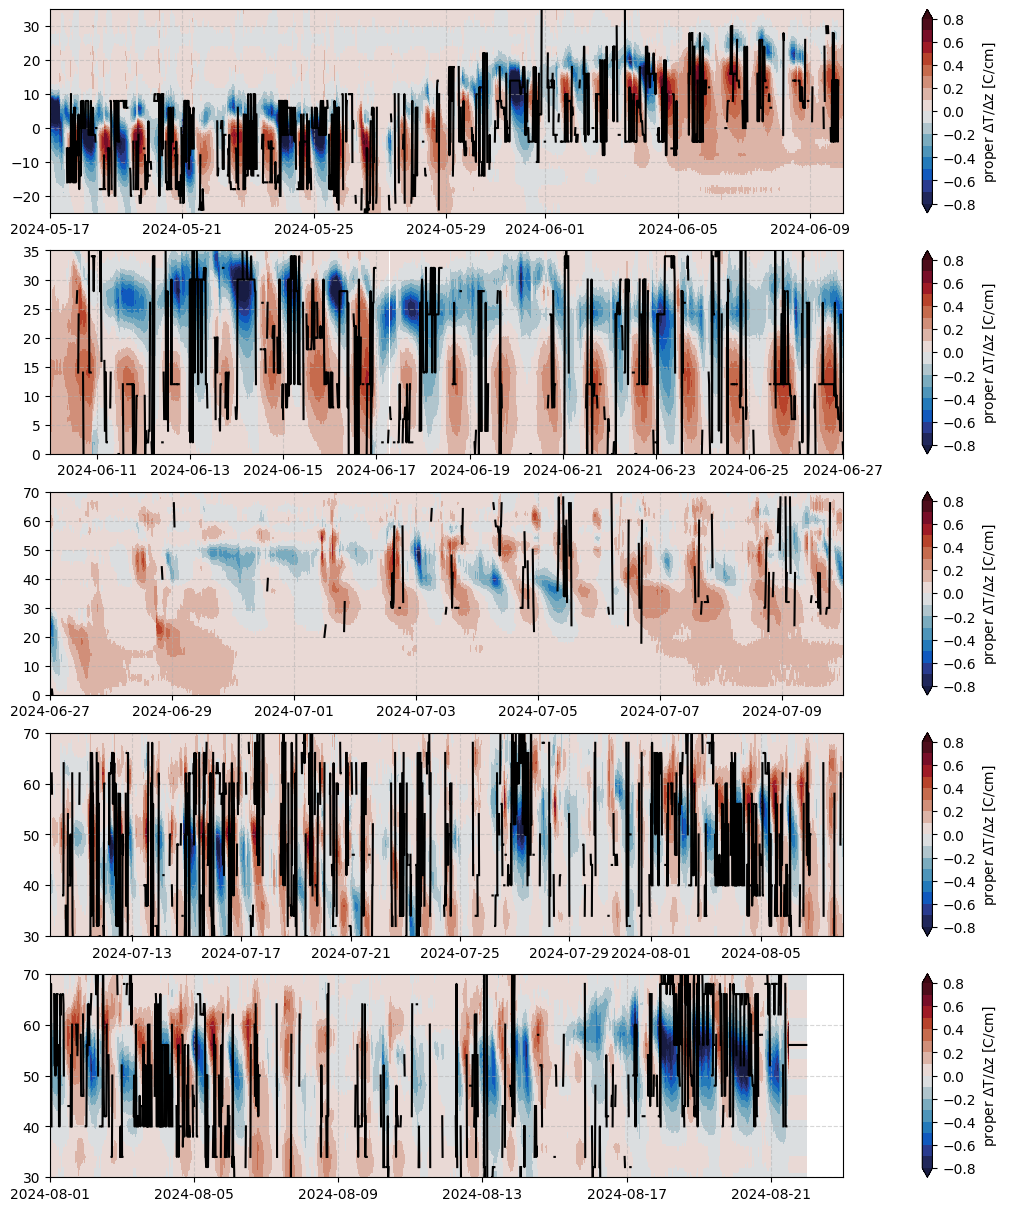

In [153]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, masked_d2Tdz2_sfc, c='k')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

In [171]:
masked_dTdz = np.ma.masked_less(vert_grad.copy(), 0.)
# masked_dTdz = np.ma.masked_less(scaled_variables['dTdz'].copy(), 0)

masked_dTdz = np.ma.masked_where( (simba_dates_2d<datetime(2024,6,27,1))&(simba_heights_2d>36), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,6,10))&(simba_heights_2d<0), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d<datetime(2024,6,10))&(simba_heights_2d>20), masked_dTdz)

masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,7,10))&(simba_heights_2d<30), masked_dTdz)
masked_dTdz = np.ma.masked_where( (simba_dates_2d>datetime(2024,6,27))&(simba_heights_2d>70), masked_dTdz)

In [182]:
max_var_sfc = []

masked_dTdz_var =scaled_variances_center['dTdz'][24*4]# np.ma.masked_array(scaled_variances_center['dTdz'][24*4], mask=masked_dTdz.mask)

for i in range(masked_dTdz_var.shape[0]):
    timestep_var = masked_dTdz_var[i,:]
    max_height = simba_heights[np.ma.where(timestep_var==np.ma.max(timestep_var))[0]]

    if len(max_height)!=1:
        max_var_sfc.append(np.nan)
    else:
        max_var_sfc.append(max_height[0])

max_var_sfc = np.array(max_var_sfc)

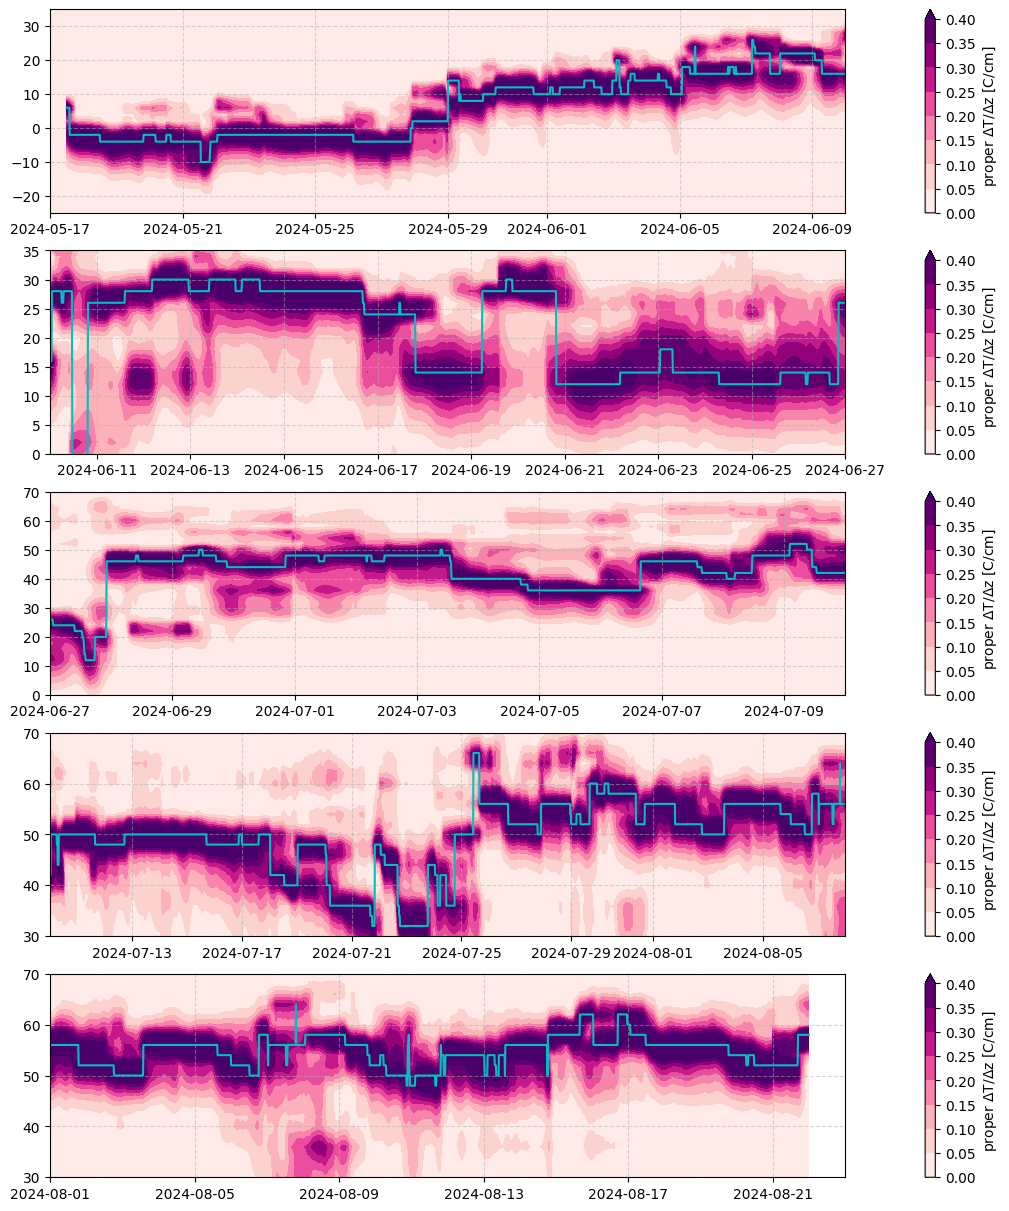

In [177]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(scaled_variances_center['dTdz'][24*4],0,1),
                    cmap=plt.cm.RdPu, levels=np.arange(0,.41,.05), extend='max')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, max_var_sfc, c='c')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

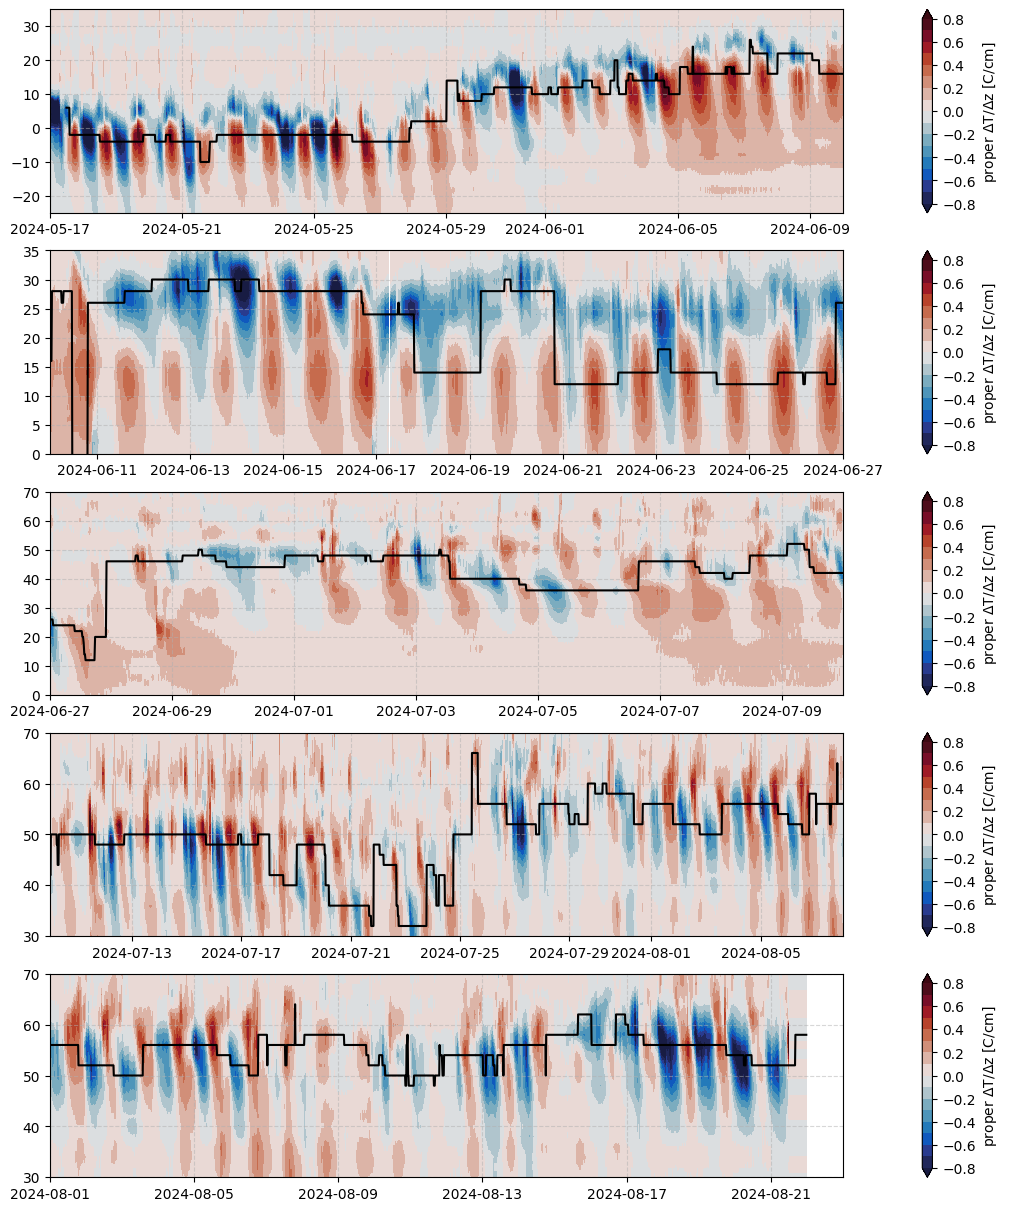

In [178]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, max_var_sfc, c='k')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

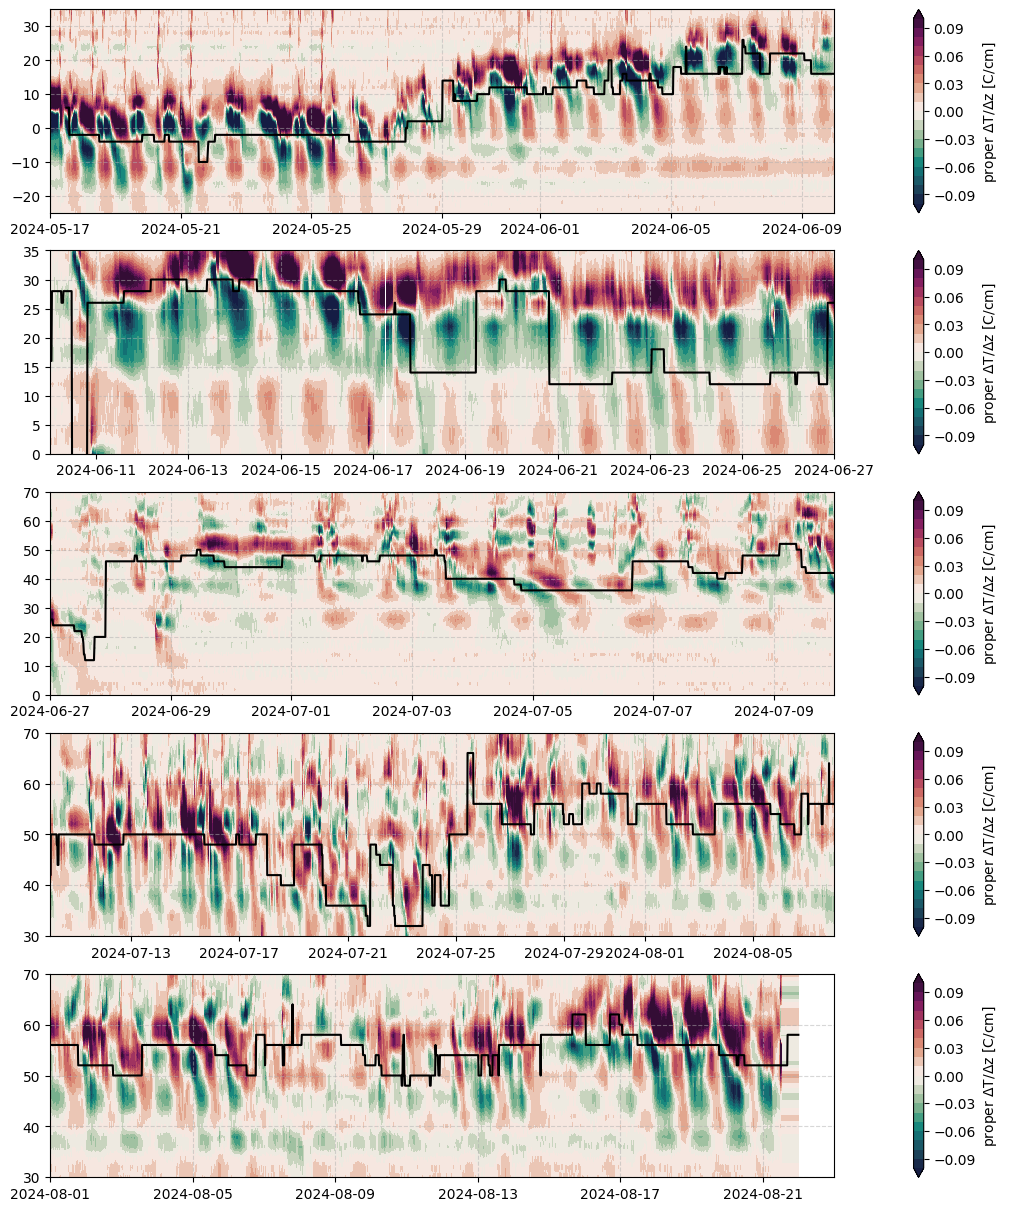

In [181]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                    cmap=cmocean.cm.curl, levels=np.arange(-.1,.11,.01), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, max_var_sfc, c='k')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

In [219]:
upper_sfc_lim = np.copy(max_var_sfc)+10.
lower_sfc_lim = np.copy(max_var_sfc)-10.

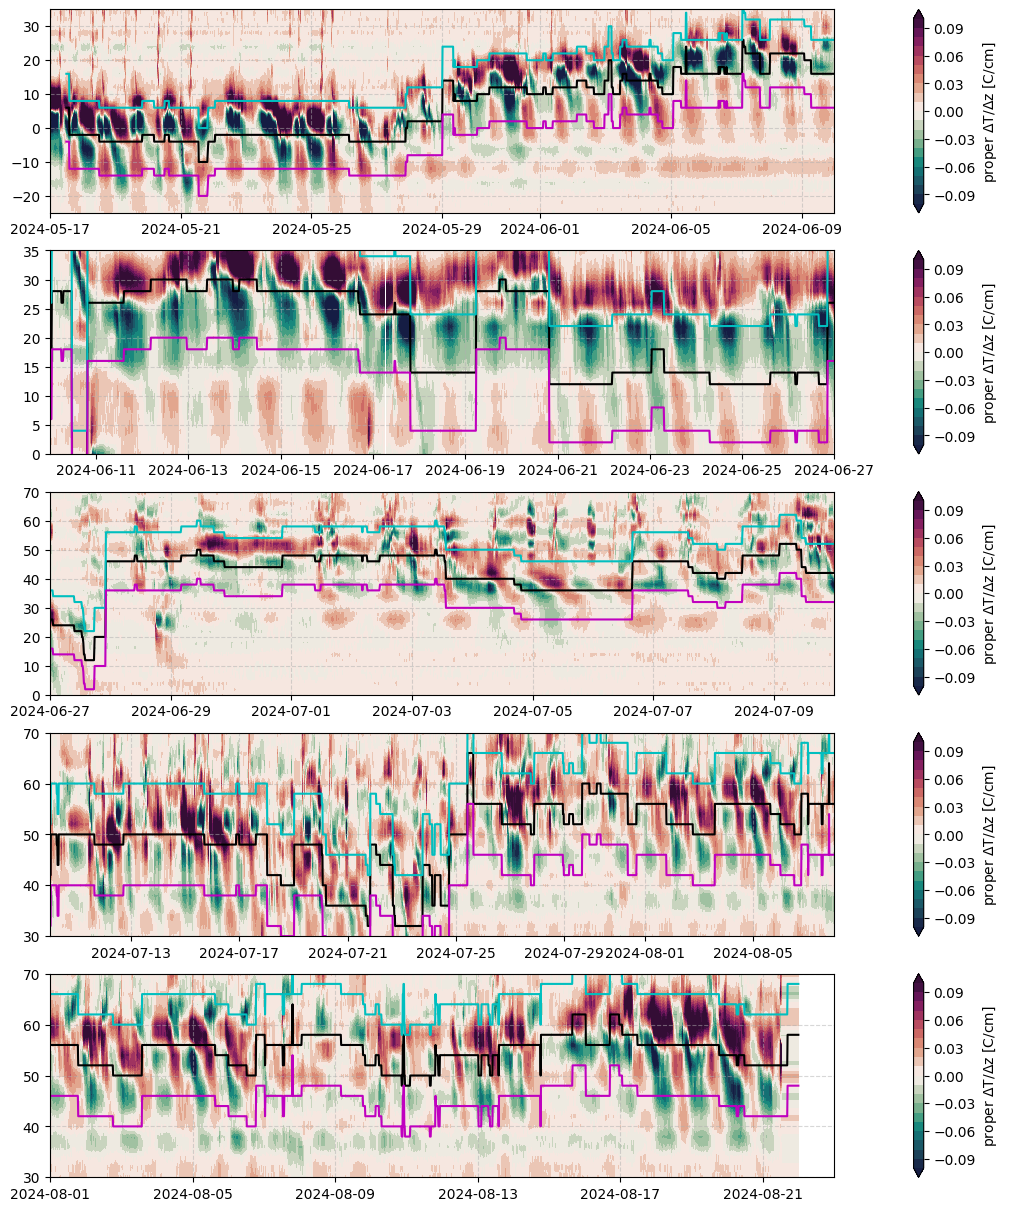

In [209]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(second_vert_grad,0,1),
                    cmap=cmocean.cm.curl, levels=np.arange(-.1,.11,.01), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, max_var_sfc, c='k')
    ax.plot(simba_dates, upper_sfc_lim, c='c')
    ax.plot(simba_dates, lower_sfc_lim, c='m')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

In [220]:
lower_2d = np.repeat(lower_sfc_lim[:,np.newaxis],simba_heights.shape,axis=1)
upper_2d = np.repeat(upper_sfc_lim[:,np.newaxis],simba_heights.shape,axis=1)

In [221]:
d2Tdz2_masked_outside = np.ma.masked_where( simba_heights_2d>upper_2d, np.copy(second_vert_grad))
d2Tdz2_masked_outside = np.ma.masked_where( simba_heights_2d<lower_2d, d2Tdz2_masked_outside)

In [222]:
limited_sfc = []

# masked_dTdz_var =scaled_variances_center['dTdz'][24*4]# np.ma.masked_array(scaled_variances_center['dTdz'][24*4], mask=masked_dTdz.mask)

for i in range(d2Tdz2_masked_outside.shape[0]):
    timestep_var = d2Tdz2_masked_outside[i,:]
    max_height = simba_heights[np.ma.where(timestep_var==np.ma.min(timestep_var))[0]]

    if len(max_height)!=1:
        limited_sfc.append(np.nan)
    else:
        limited_sfc.append(max_height[0])

limited_sfc = np.array(limited_sfc)

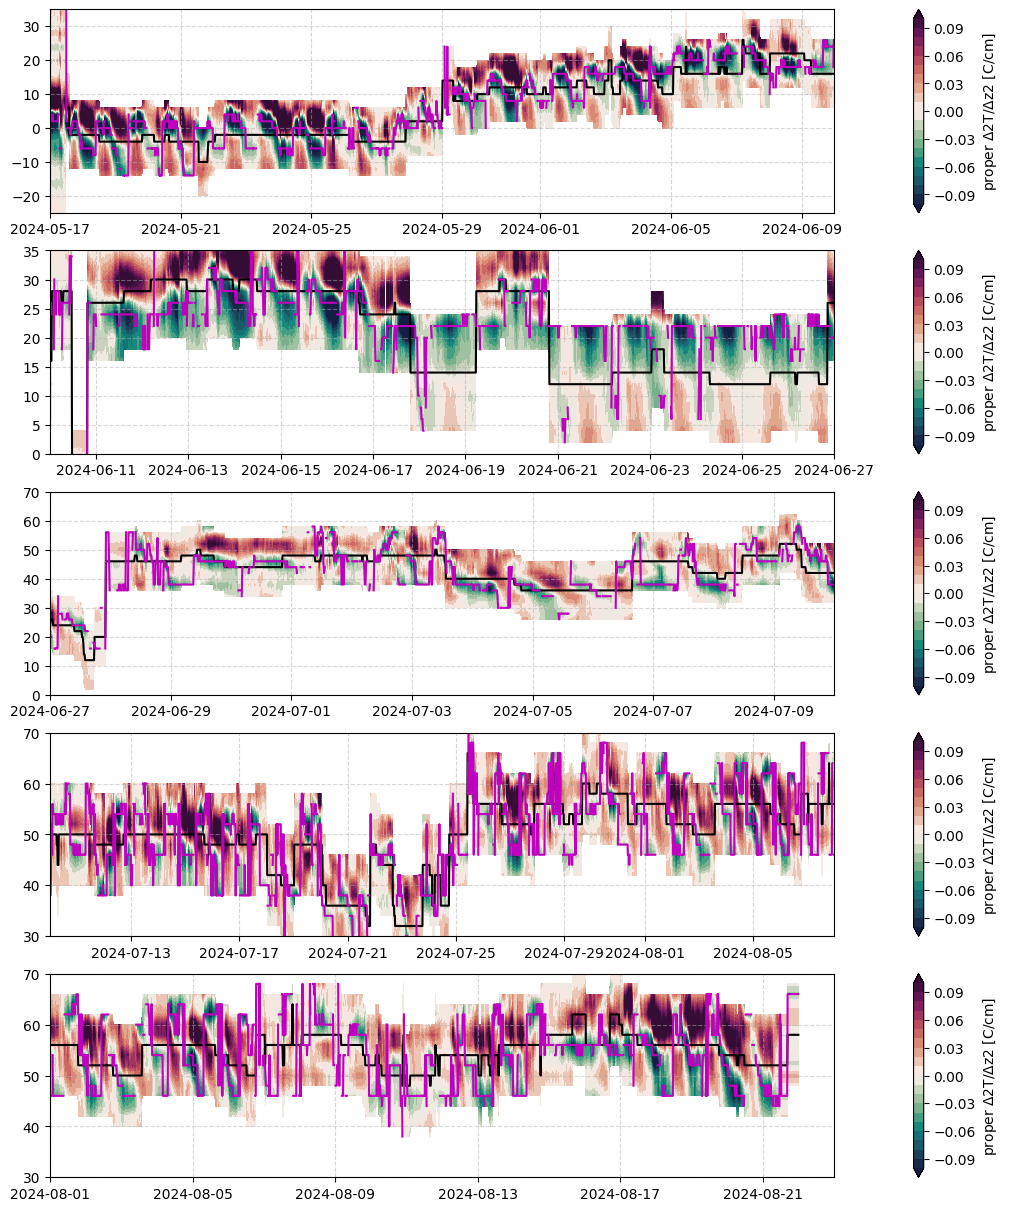

In [224]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(d2Tdz2_masked_outside,0,1),
                    cmap=cmocean.cm.curl, levels=np.arange(-.1,.11,.01), extend='both')
    plt.colorbar(cb, label='proper $\Delta$2T/$\Delta$z2 [C/cm]', ax=ax)

    
    ax.plot(simba_dates, max_var_sfc, c='k')
    ax.plot(simba_dates, limited_sfc, c='m')
    # ax.plot(simba_dates, lower_sfc_lim, c='m')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()

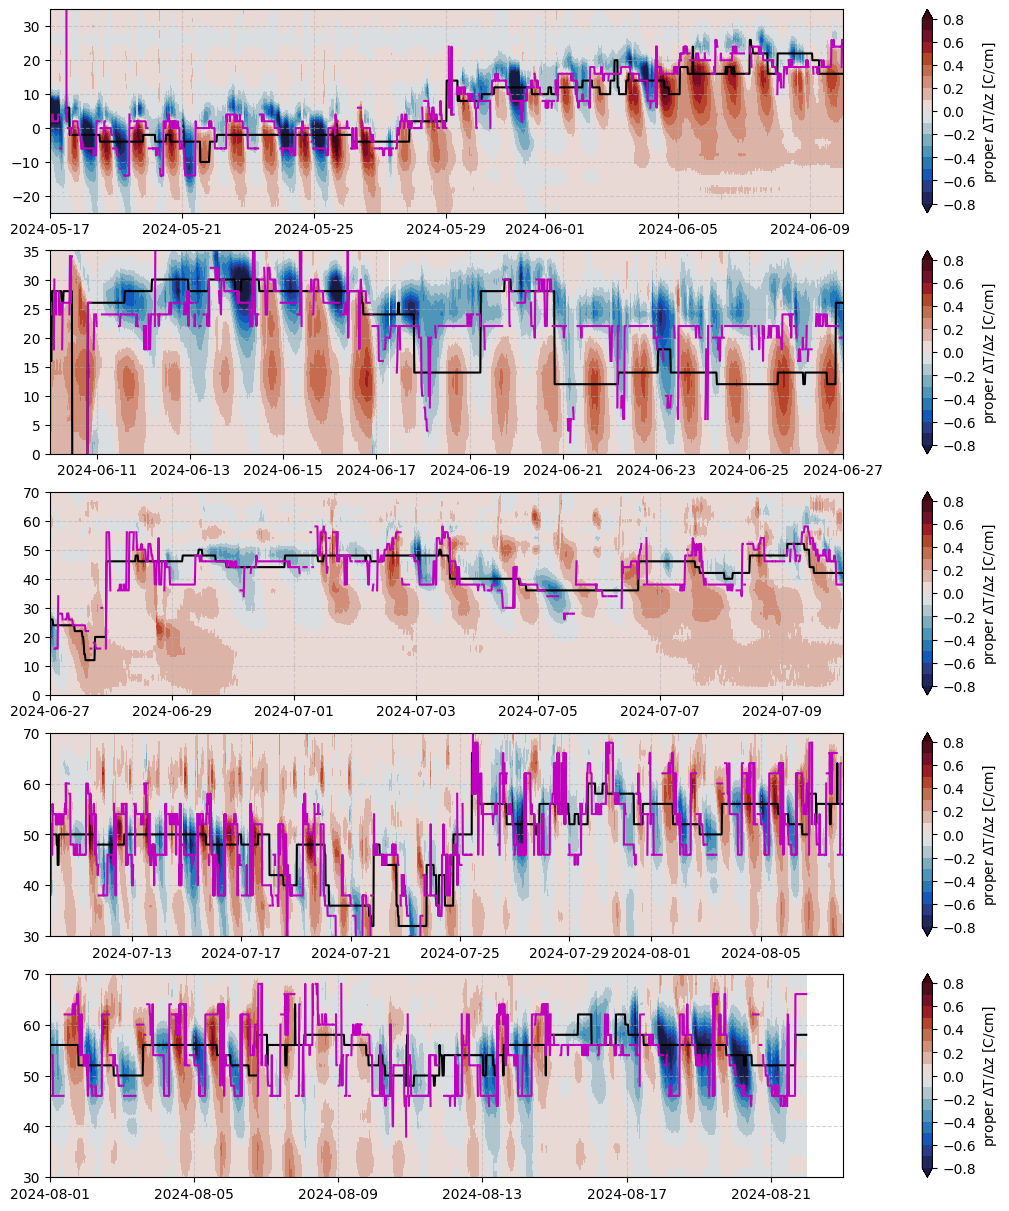

In [225]:
fig, axs = plt.subplots(5, figsize=(10,12),  constrained_layout=True)

ylims = [(-25,35),(0,35),(0,70),(30,70),(30,70)]
xlims = [(datetime(2024,5,17), datetime(2024,6,10)), (datetime(2024,6,10),datetime(2024,6,27)),
         (datetime(2024,6,27),datetime(2024,7,10)),(datetime(2024,7,10),datetime(2024,8,8)),
         (datetime(2024,8,1),datetime(2024,8,23))]
for i, ax in enumerate(axs.ravel()):
    cb = ax.contourf(simba_dates, simba_heights, np.swapaxes(vert_grad,0,1),
                    cmap=cmocean.cm.balance, levels=np.arange(-.8,.81,.1), extend='both')
    plt.colorbar(cb, label='proper $\Delta$T/$\Delta$z [C/cm]', ax=ax)

    
    ax.plot(simba_dates, max_var_sfc, c='k')
    ax.plot(simba_dates, limited_sfc, c='m')

    ax.set_ylim(ylims[i])
    ax.set_xlim(xlims[i])
    ax.grid(alpha=.5, ls='--')
    
plt.show()